# Preparando datos para armar un motor de trading

En la industria del trading algorítmico, las etiquetas para predicción no están del todo claras en un comienzo. Además, el hecho de estar trabajando con series de tiempo complica el trabajo. Vamos a dejar un poco de lado este hecho y vamos a "jugar" un poco con los datos.

Esta vez vamos a trabajar con datos de acciones argentinas y vamos a ver qué podemos encontrar. Una acción o "stock", como se la conoce en inglés, es un título público que emiten las empresas para obtener inversión para sus proyectos. Es diferente a los bonos, ya que no tiene flujos de fondos a futuro, si no que representa la posibilidad de ser parte de la sociedad. Al comprar acciones de una empresa, estamos siendo socios de la misma y el valor de nuestra participación puede subir y bajar con las buenas y las malas que pase la empresa. Como podemos adivinar, este mercado es aún más volátil que el de los bonos (algo que en Argentina no es poco decir...).

En los mercados no solamente existen los precios de las acciones, si no que hay índices que trackean el rendimiento en general de las mismas. Para Argentina, el índice principal es el Merval (Qué es? [shameless plug](https://blog.invera.com.ar/qu%C3%A9-es-el-merval-6ce8df474e8c)). La metodología de cálculo del Merval se puede ver en la bibliografía del repositorio.

Comencemos como en el práctico anterior (hace tantos años...), descargando los datos con los cuales vamos a trabajar desde la página web de Rava, que ahora nos deja invertir en la bolsa armando una cuenta con ellos (qué bien!), siempre y cuando tengamos al menos 300.000 pesos para invertir (qué mal).

In [1]:
### Needed imports
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy import optimize
%matplotlib inline
import sys
from io import StringIO

### Lista de acciones argentinas ###
stocks_list = [
    'AGRO', 'ALUA', 'APBR', 'AUSO', 'BBAR', 'BHIP', 'BMA', 'BOLT', 'BPAT', 'BRIO', 'BYMA', 'CARC',
    'CAPU', 'CELU', 'CEPU', 'CGPA2', 'COME', 'CRES', 'CTIO', 'CVH', 'DGCU2', 'EDN', 'GCLA', 'GGAL', 'HAVA',
    'INDU', 'IRSA', 'LEDE', 'LOMA', 'LONG', 'METR', 'MIRG', 'MOLA', 'MOLI', 'MORI', 'OEST', 'PAMP',
    'PATY', 'PGR', 'SAMI', 'SUPV', 'TECO2', 'TGLT', 'TGNO4', 'TGSU2', 'TRAN', 'TS', 'TXAR', 'VALO', 'YPFD',
    ### Agregamos el índice de acciones argentinas: Merval
    'MERVAL',
]

In [2]:
### Obtengamos los datos y los guardemos por si las moscas...
for stock in stocks_list:
    url = 'http://www.ravabursatil.com/v2/empresas/precioshistoricos.php?e={}&csv=1'.format(stock)
    req = requests.get(url, allow_redirects=True)
    df = pd.read_csv(StringIO(req.content.decode("utf-8")))
    name = './stocks/{}.csv'.format(stock)
    df.to_csv(name)

# Hagamos Análisis Técnico!

El *análisis técnico* es el "arte" (no me atrevo a llamar a esto ciencia) de predecir los movimientos futuros de los activos financieros en base a su comportamiento en el pasado. Como con la predicción del clima, puede no ser preciso, pero quizás dé algunas ideas de cómo se pueden llegar a mover ciertos activos y se puede tomar decisiones de inversión a partir de esto.

Vamos a tener ciertas suposiciones claves para hacer con respecto a esto:
- **Alta liquidez**: Se asume que las acciones con las que se trabaja tienen un alto volumen de negociación. Si una acción se negocia mucho, es mucho más difícil manipular su precio, por lo que seguiría un curso "de manual", si es que se encuentra ese manual...
- **No hay cambios artificiales de precios**: Las acciones pagan dividendos (como el cupón de un bono) o, en algunos casos, pueden ser divididas (mediante una acción que se denomina "split"). Estas acciones pueden cambiar de manera artificial el precio de una acción. Para poder tener esto en cuenta, es necesario tener el precio de una acción "ajustado" por sus movimientos artificiales. Por suerte, la data de RAVA ya viene con esto solucionado.
- **No hay "cisnes negros"**: El análisis técnico no puede tener en cuenta noticias externas que puedan afectar al desempeño de una acción de manera sorpresiva, como por ejemplo la muerte de su CEO o un ataque terrorista en el que se viera afectada.

En resumen, el análisis técnico utiliza la información capturada en el precio de un activo para interpretar qué es lo que el mercado dice, para formar una visión del futuro.

Claramente, esto puede sonar a chamuyo, pero puede ser algo de qué agarrarse cuando no se tiene mucha más información con la cual trabajar, ya que ha mostrado ser de utilidad en mercados muy grandes, como en EE.UU.

### Será posible aplicarlo en el mercado argentino? ###

Otra cosa a tener en cuenta: Los datos históricos de mercado generan **series de tiempo**, que son un fenómeno un poco lejano a los datos estáticos. En este práctico vamos a probar las herramientas aprendidas en la teoría y ver si pueden tener incidencia a la hora de trabajar con estas series de tiempo.

Vamos a hacer todo esto primero con las acciones del Grupo Financiero Galicia (GGAL), para tener una idea de cómo se ve, aplicando la librería de pandas `ta` (https://github.com/bukosabino/ta)

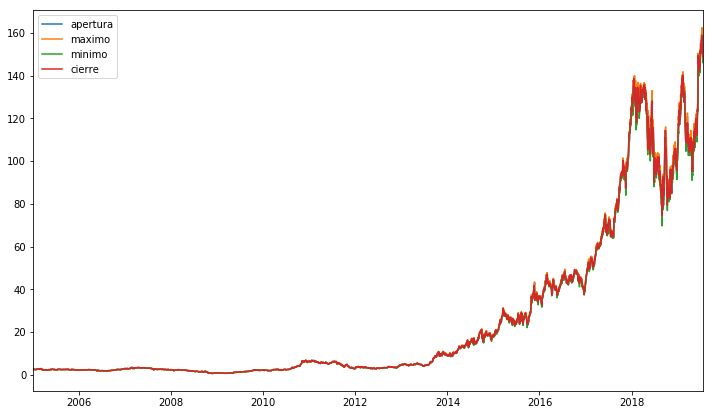

In [3]:
ggal = pd.read_csv('stocks/GGAL.csv', usecols=['fecha', 'apertura', 'minimo', 'maximo', 'cierre', 'volumen'], index_col='fecha')
ggal.index = pd.to_datetime(ggal.index).date
ggal.drop('volumen', axis=1).plot(figsize=(12,7))
#merval.count()

# Indicadores Técnicos #

La librería TA tiene varios de los más usados, veamos:

- Medias Móviles: Se hace un promedio de los precios anteriores al día que se está tomando. Existen dos de las medias más comunes. La media *simple* (SMA) hace un promedio simple de los precios pasados, mientras que la media *exponencial* (EMA) multiplica cada elemento por un peso que va creciendo de manera exponencial hasta el presente. Aquí el hiperparámetro importante es la cantidad de períodos hacia atrás que se usan en el cálculo. Las medias móviles son indicadores de *tendencia* del precio de un activo (https://www.investopedia.com/terms/m/movingaverage.asp).
- Bandas de Bollinger (BB): Indicador de volatilidad, Una vez se tiene la media móvil, se dibuja además un valor de dos desviaciones estándar hacia arriba y hacia abajo del precio del activo (https://en.wikipedia.org/wiki/Bollinger_Bands).
- Línea de Acumulación/Distribución (ADL/I): Indicador que utiliza el volumen de venta, junto con los precios del activo. Su fórmula de cálculo se encuentra en https://www.investopedia.com/terms/a/accumulationdistribution.asp. Ayuda a ver cuán fuerte es una tendencia, ya que si un precio sube y este indicador no lo hace, quiere decir que no hay suficiente ímpetu como para mantener la suba y puede volver a bajar.

Existen mucho más ejemplos, los cuales están en la documentación y la librería, probemos uno.

In [7]:
import ta
# Ejemplo agregando bandas de Bollinger (https://www.investopedia.com/terms/b/bollingerbands.asp)
ggal['upper_bb'] = ta.bollinger_hband(ggal['cierre'], n=20, ndev=2, fillna=True)
ggal['lower_bb'] = ta.bollinger_lband(ggal['cierre'], n=20, ndev=2, fillna=True)

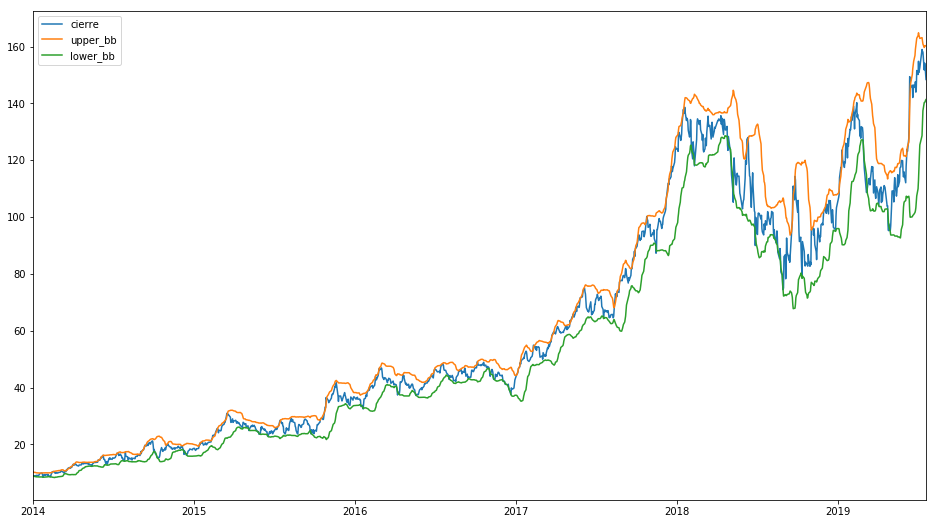

In [16]:
# Veamos desde el año 2014 en adelante...
from datetime import date
year_2014 = date(2014,1,1)
ggal.loc[year_2014:,['cierre', 'upper_bb', 'lower_bb']].plot(figsize=(16,9))

# Qué vamos a hacer? #

Lo importante aquí es aprender cómo actuar a partir de cada señal que se recibe. Para eso comenzaremos a hacer *backtesting*, es decir, vamos a implementar una estrategia de inversión y la vamos a testear en el pasado, para ver si tiene sentido aplicarla.

Por ejemplo, la "teoría" de las bandas de Bollinger dice que las señales de compra se emiten cuando el precio está por debajo de la banda inferior y habría que vender el activo cuando el precio se va por encima de la banda superior. Es posible hacer de forma automática la señal de las bandas con la librería `ta`, el ejemplo está en su github. Para juntar información de más de una media móvil se puede usar el indicador MACD.

Tenemos que etiquetar nuestros datos si queremos aplicar un poco de aprendizaje supervisado! Para eso, vamos a crear etiquetas simples, para saber si al comprar la acción se ganó dinero. Vamos a tomar el precio de la acción en una fecha y compararlo con el precio en una fecha hacia adelante. Podemos usar una semana, o un mes, o quizás hasta un año. Por ahora, hagamos estrategias mensuales. Para eso, habrá que ir aproximadamente 20 puntos hacia adelante en el tiempo (tener en cuenta que los datos que tenemos son para días hábiles) y etiquetemos con 1 si el precio subió o -1 si el precio bajó.

In [17]:
# Hacerlo acá

Una vez las etiquetas estén listas, comencemos a juntar señales, que van a ser nuestros features! Utilizar algunas de la lista que figura en el Github de `ta`, son muchas, así que tomar algunas que parezcan interesantes o que pueden agregar variabilidad a los resultados (cómo podríamos ver eso?):

#### Volume

* Accumulation/Distribution Index (ADI)
* On-Balance Volume (OBV)
* Chaikin Money Flow (CMF)
* Force Index (FI)
* Ease of Movement (EoM, EMV)
* Volume-price Trend (VPT)
* Negative Volume Index (NVI)

#### Volatility

* Average True Range (ATR)
* Bollinger Bands (BB)
* Keltner Channel (KC)
* Donchian Channel (DC)

#### Trend

* Moving Average Convergence Divergence (MACD)
* Average Directional Movement Index (ADX)
* Vortex Indicator (VI)
* Trix (TRIX)
* Mass Index (MI)
* Commodity Channel Index (CCI)
* Detrended Price Oscillator (DPO)
* KST Oscillator (KST)
* Ichimoku Kinkō Hyō (Ichimoku)

#### Momentum

* Money Flow Index (MFI)
* Relative Strength Index (RSI)
* True strength index (TSI)
* Ultimate Oscillator (UO)
* Stochastic Oscillator (SR)
* Williams %R (WR)
* Awesome Oscillator (AO)

#### Others

* Daily Return (DR)
* Daily Log Return (DLR)
* Cumulative Return (CR)

Vamos a dejarlas en el mismo DataFrame `ggal`, como hicimos con las bandas de Bollinger. 

In [18]:
# Hacerlo acá

#### ¿Cuáles parecen ser las mejores señales para inferir 'algo'?

El año 2018 fue muuuuy movido para las acciones argentinas, va a ser divertido que hagamos training sobre todos los datos justo hasta ese año y nuestro conjunto de test sería todo lo que queda.

Hagamos clasificación binaria, ya que tenemos nuestras etiquetas +1 y -1. K Nearest Neighbors parece interesante para hacer esto, pero también probar algún otro clasificador.

Reportar:

- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Si tomamos la decisión de comprar la acción cuando la etiqueta es +1 y vender (quedarnos con el dinero) cuando la etiqueta es -1 al comienzo de cada mes desde el 01/01/2019, cómo nos habrá ido? Supongamos que comenzamos con \$10.000 y tomemos la diferencia porcentual entre el precio de Cierre del primer día de cada mes para ver si ganamos dinero. Con esto completaríamos un flow de backtesting y vamos a poder evaluar si esta estrategia funciona con la acción GGAL.

Se podría ver si es posible probar esto con otras acciones.